## Setup

In [10]:
# Facial image emotion recognition using CNN
# Target classes: Angry, Disgusted, Fearful, Happy, Sad, Surprised, Neutral

import tensorflow as tf

NUM_THREADS = 32

tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

# Switch to GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


# DATASET
# files in dataset/test and dataset/train
# subfolders: angry, disgusted, fearful, happy, sad, surprised, neutral

# load dataset
train_dir = 'dataset_RAF_DB/train'
test_dir = 'dataset_RAF_DB/test'

model = None
modelName = 'model_RAF_DB_ResNet'

greyscale = False
augmentation = False

# Number of augmentations per image
num_augmentations = 10

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
# Test data
# Check for the number of images in each class and the size of the images
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # 0 = all messages are logged

# List of classes
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Number of images in each class
print('Number of training images in each class:')
for c in classes:
    path = os.path.join(train_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
print('\nNumber of test images in each class:')
for c in classes:
    path = os.path.join(test_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
# Image size
img = cv2.imread('dataset_RAF_DB/train/angry/train_00023_aligned.jpg')
print(f'\nImage size: {img.shape}')

input_shape = img.shape

Number of training images in each class:
angry: 705 images
disgust: 717 images
fear: 281 images
happy: 4772 images
neutral: 2524 images
sad: 1982 images
surprise: 1290 images

Number of test images in each class:
angry: 162 images
disgust: 160 images
fear: 74 images
happy: 1185 images
neutral: 680 images
sad: 478 images
surprise: 329 images

Image size: (100, 100, 3)


## Preparing different models

In [10]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import layers, models, optimizers

# load ResNet50 without top layer 
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Neue Modellspitze hinzufügen
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))

# Freeze the base model layers (not to be trained; unfreeze for fine-tuning after first training)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ ?                      │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,331,648 (222.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,331,648 (222.52 MB)

## Loading the images from disk

In [12]:
def normalize_image(img):
    img = tf.cast(img, tf.float32) / 255.0  # normalize to [0,1] range
    return img

# Load the data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',  # Integer-Labels
    image_size=(100, 100),
    batch_size=64,
    color_mode='grayscale' if greyscale else 'rgb',
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',  # Integer-Labels
    image_size=(100, 100),
    batch_size=64,
    color_mode='grayscale' if greyscale else 'rgb',
)

# Normalize the images to [0,1]
train_ds = train_ds.map(lambda img, label: (normalize_image(img), label))
test_ds = test_ds.map(lambda img, label: (normalize_image(img), label))

# One-Hot-Encoding of the labels
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=num_classes)
    return image, label

num_classes = 7

train_ds = train_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

Found 12271 files belonging to 7 classes.
Found 3068 files belonging to 7 classes.


In [13]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.5)
    img = tf.image.random_contrast(img, lower=0.6, upper=1.4)
    # Some augmentations are only applicable to RGB images
    if not greyscale:
        img = tf.image.random_hue(img, max_delta=0.2)
        img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    return img, label

def augment_multiple(img, label, num_augmentations=5):
    augmented_images = []
    augmented_labels = []
    for _ in range(num_augmentations):
        augmented_img, augmented_label = augment(img, label)
        augmented_images.append(augmented_img)
        augmented_labels.append(augmented_label)
    return tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))

# Augment the training data
if augmentation:
    augmented_datasets = train_ds.flat_map(lambda img, label: augment_multiple(img, label, num_augmentations))
    train_ds = train_ds.concatenate(augmented_datasets)

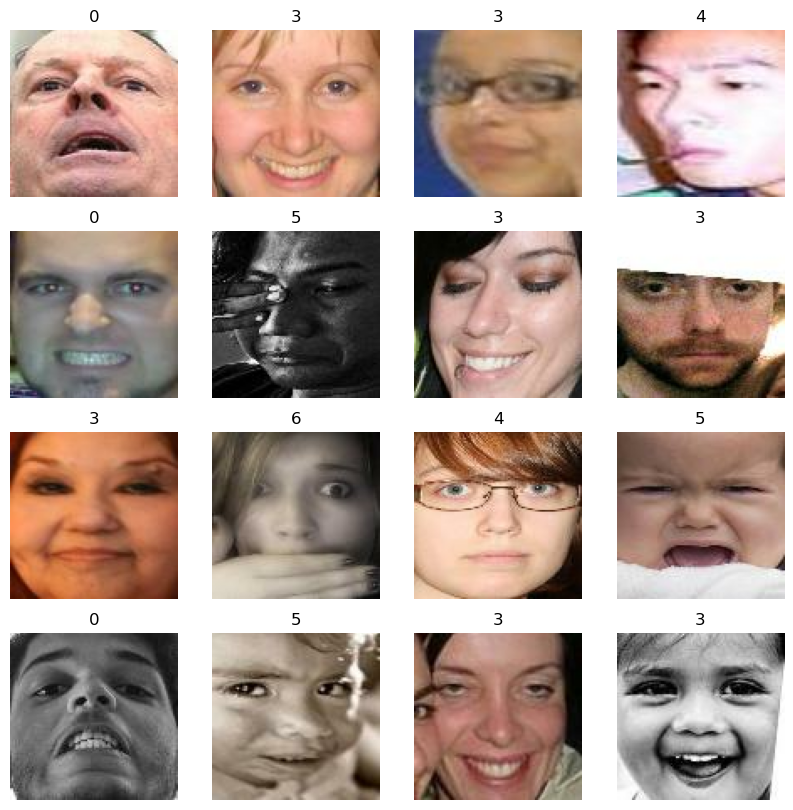

2024-07-09 07:55:07.510861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Show the first 16 images and their labels
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        if greyscale:
            plt.imshow(np.squeeze(images[i]), cmap='gray')
        else:
            plt.imshow(images[i])
        plt.title(np.argmax(labels[i]))
        plt.axis('off')
    plt.show()


Image shape: (64, 100, 100, 3), Label dtype: <dtype: 'float32'>
Image dtype: <dtype: 'float32'>, Label dtype: <dtype: 'float32'>


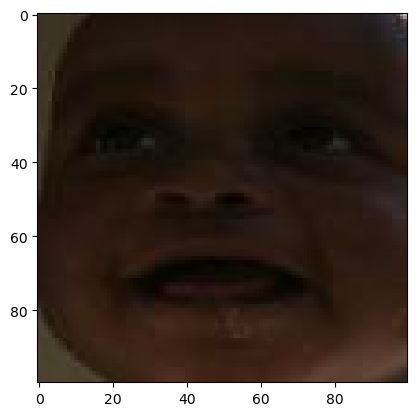

2024-07-09 07:55:14.022594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
# Print one image (to confirm whether the images are represented as 48x48x1 tensors)
for img, label in train_ds.take(1):
    print(f"Image shape: {img.shape}, Label dtype: {label.dtype}")
    print(f"Image dtype: {img.dtype}, Label dtype: {label.dtype}")
    
    # Plot the image
    if greyscale:
        plt.imshow(np.squeeze(img[0]), cmap='gray')
    else:
        plt.imshow(img[0])
    plt.show()

## Class distribution and weights

In [16]:
import collections

def get_class_distribution(dataset):
    class_counts = collections.Counter()
    
    for _, label_batch in dataset:
        labels = tf.argmax(label_batch, axis=1)
        class_counts.update(labels.numpy())
    
    return class_counts

# Klassenverteilung im Trainingsdatensatz
train_class_distribution = get_class_distribution(train_ds)
print("Train Class Distribution:", train_class_distribution)

# Klassenverteilung im Testdatensatz
test_class_distribution = get_class_distribution(test_ds)
print("Test Class Distribution:", test_class_distribution)


2024-07-09 07:55:20.727129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Class Distribution: Counter({3: 4772, 4: 2524, 5: 1982, 6: 1290, 1: 717, 0: 705, 2: 281})
Test Class Distribution: Counter({3: 1185, 4: 680, 5: 478, 6: 329, 0: 162, 1: 160, 2: 74})


2024-07-09 07:55:21.317022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
import sklearn
from sklearn.utils import class_weight

# Load test data
x_train = []
y_train = []

for i, c in enumerate(classes):
    path = os.path.join(train_dir, c)
    for img_name in os.listdir(path):
        # img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            # img = cv2.resize(img, (48, 48))
            # x_train.append(img)
            y_train.append(i)

In [18]:
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)

# Nehme an, y_train_labels sind die Labels deiner Trainingsdaten
y_train_labels = np.argmax(y_train_encoded, axis=1)
y_train_labels = y_train_labels.astype(np.int32)

# Berechnung der Klassengewichte
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_labels),
                                                  y=y_train_labels)

# Convert the class weights to a dictionary. Use np.int32 as the key type
class_weights_dict = {int(k): float(v) for k, v in zip(np.unique(y_train_labels), class_weights)}

print("Class weights:", class_weights_dict)
# Print the type of keys in the dictionary
print("Type of keys:", type(list(class_weights_dict.keys())[0]))
# Print the type of values in the dictionary
print("Type of values:", type(list(class_weights_dict.values())[0]))

Class weights: {0: 2.4865248226950354, 1: 2.4449093444909344, 2: 6.238434163701068, 3: 0.3673512154233026, 4: 0.884460141271443, 5: 1.3589147286821706, 6: 0.6945324881141046}
Type of keys: <class 'int'>
Type of values: <class 'float'>


# Custom Callbacks

In [ ]:
# Callback function to print the best value of a metric (to roughly predict when the training will finish due to early stopping)
class RecordMetricCallback(tf.keras.callbacks.Callback):
    def __init__(self, metric='val_loss', mode='min'):
        super(RecordMetricCallback, self).__init__()
        self.metric = metric
        self.mode = mode
        self.best_epoch = -1
        self.best_value = None
        if mode == 'min':
            self.best_value = float('inf')
        elif mode == 'max':
            self.best_value = -float('inf')
        else:
            raise ValueError("Mode must be 'min' or 'max'")

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get(self.metric)
        if current_value is not None:
            if (self.mode == 'min' and current_value < self.best_value) or (self.mode == 'max' and current_value > self.best_value):
                self.best_value = current_value
                self.best_epoch = epoch
            print(f'Best {self.metric} so far: {self.best_value} (Epoch {self.best_epoch + 1})')

# Callbacks

In [19]:
metric = 'val_accuracy'
mode = 'max'

# Callback functions
early_stopping = tf.keras.callbacks.EarlyStopping(monitor=metric, patience=15, restore_best_weights=True, mode=mode)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=metric, factor=0.2, patience=5, min_lr=1e-7, mode=mode)
record_val_accuracy = RecordMetricCallback(metric=metric, mode=mode)

In [20]:
for image, label in train_ds.take(1):  # Only take the first batch
    print(label[0])  # Show the label

tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)


2024-07-09 07:55:30.257548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training & Evaluation

In [21]:
history = model.fit(
    train_ds,
    class_weight=class_weights_dict,
    epochs=5000,
    validation_data=test_ds,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/5000


I0000 00:00:1720504540.764189    1457 service.cc:145] XLA service 0x7f20c40b2af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720504540.764225    1457 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-07-09 07:55:41.019866: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-09 07:55:42.193916: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1720504543.543521    2561 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_22864', 428 bytes spill stores, 428 bytes spill loads

I0000 00:00:1720504543.588059    2568 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_22864', 492 bytes spill stores, 492 bytes spill loads

I

  7/192 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2127 - loss: 4.2027 

I0000 00:00:1720504547.194469    1457 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


190/192 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3105 - loss: 2.5471

I0000 00:00:1720504553.713828    2684 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15464', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1720504553.767116    2673 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15464', 244 bytes spill stores, 244 bytes spill loads

I0000 00:00:1720504553.818510    2664 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_22864', 436 bytes spill stores, 436 bytes spill loads

I0000 00:00:1720504553.838404    2657 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_22864', 444 bytes spill stores, 444 bytes spill loads



192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3110 - loss: 2.5420

I0000 00:00:1720504562.726011    2886 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4441', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1720504562.796665    2883 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4441', 244 bytes spill stores, 244 bytes spill loads



192/192 ━━━━━━━━━━━━━━━━━━━━ 31s 95ms/step - accuracy: 0.3112 - loss: 2.5395 - val_accuracy: 0.4596 - val_loss: 1.5054 - learning_rate: 0.0010
Epoch 2/5000
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.4144 - loss: 1.6521 - val_accuracy: 0.4733 - val_loss: 1.4388 - learning_rate: 0.0010
Epoch 3/5000
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.4506 - loss: 1.5492 - val_accuracy: 0.4863 - val_loss: 1.4075 - learning_rate: 0.0010
Epoch 4/5000
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.4695 - loss: 1.4689 - val_accuracy: 0.5114 - val_loss: 1.3656 - learning_rate: 0.0010
Epoch 5/5000
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.4917 - loss: 1.4004 - val_accuracy: 0.4759 - val_loss: 1.4125 - learning_rate: 0.0010
Epoch 6/5000
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.4985 - loss: 1.3486 - val_accuracy: 0.4925 - val_loss: 1.3631 - learning_rate: 0.0010
Epoch 7/5000
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5052 - loss: 

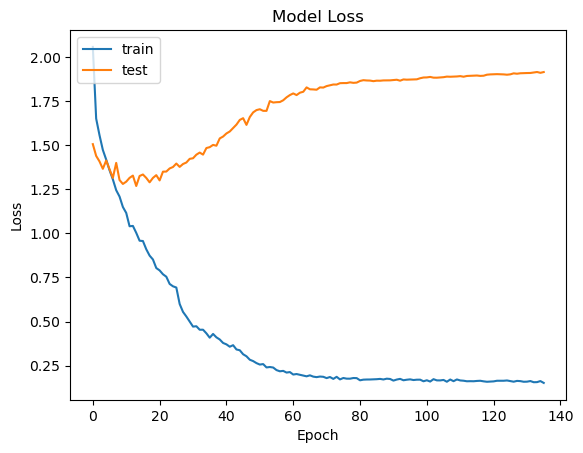

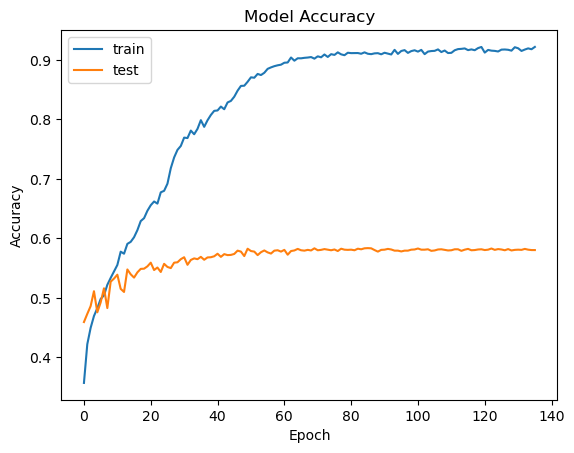

In [22]:
# Plot training history (loss and accuracy)
# Plot the point with the best validation accuracy (early stopping)
# Plot the point with the least validation loss
from textwrap import fill
from turtle import fillcolor, filling


highest_val_acc = np.argmax(history.history['val_accuracy'])
highest_val_acc_item = (highest_val_acc, history.history['val_accuracy'][highest_val_acc])

lowest_val_loss = np.argmin(history.history['val_loss'])
lowest_val_loss_item = (lowest_val_loss, history.history['val_loss'][lowest_val_loss])

plt.plot(history.history['loss'], c="C0", label="train")
plt.plot(history.history['val_loss'], c="C1", label="test")
plt.plot(lowest_val_loss_item[0], lowest_val_loss_item[1], '.', markersize=20, color="C2", label=f"Lowest val loss = {lowest_val_loss_item[1]:.3f} ")
plt.title(modelName + 'Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], c="C0", label="train")
plt.plot(history.history['val_accuracy'], c="C1", label="test")
plt.plot(highest_val_acc_item[0], highest_val_acc_item[1], '.', markersize=20, color="C2", label=f"Highest val acc = {highest_val_acc_item[1]:.3f}")
plt.title(modelName + 'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

In [23]:
# Fine-tuning
# Unfreeze the base model and train the entire model

for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    epochs=5000,
    validation_data=test_ds,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/5000


I0000 00:00:1720505470.897727    1456 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_64', 8 bytes spill stores, 8 bytes spill loads



191/192 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4235 - loss: 2.2862

I0000 00:00:1720505518.204949    1455 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_64', 8 bytes spill stores, 8 bytes spill loads



192/192 ━━━━━━━━━━━━━━━━━━━━ 116s 281ms/step - accuracy: 0.4243 - loss: 2.2791 - val_accuracy: 0.6157 - val_loss: 1.4373 - learning_rate: 1.0000e-04
Epoch 2/5000
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6642 - loss: 0.9734 - val_accuracy: 0.7187 - val_loss: 0.8449 - learning_rate: 1.0000e-04
Epoch 3/5000
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.7733 - loss: 0.6313 - val_accuracy: 0.7337 - val_loss: 0.8309 - learning_rate: 1.0000e-04
Epoch 4/5000
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.8622 - loss: 0.3961 - val_accuracy: 0.7119 - val_loss: 0.9539 - learning_rate: 1.0000e-04
Epoch 5/5000
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.9024 - loss: 0.2945 - val_accuracy: 0.7598 - val_loss: 0.9309 - learning_rate: 1.0000e-04
Epoch 6/5000
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9371 - loss: 0.1922 - val_accuracy: 0.7484 - val_loss: 1.0322 - learning_rate: 1.0000e-04
Epoch 7/5000
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 

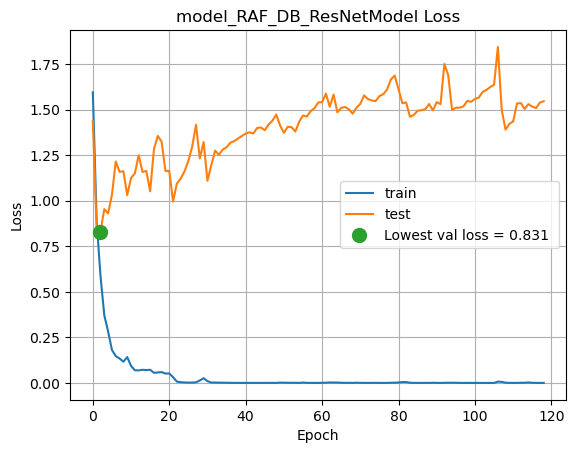

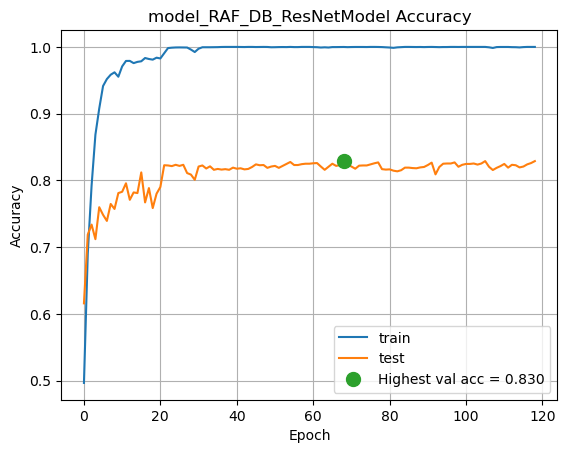

In [35]:
# Plot training history (loss and accuracy)
# Plot the point with the best validation accuracy (early stopping)
# Plot the point with the least validation loss
from textwrap import fill
from turtle import fillcolor, filling


highest_val_acc = np.argmax(history.history['val_accuracy'])
highest_val_acc_item = (highest_val_acc, history.history['val_accuracy'][highest_val_acc])

lowest_val_loss = np.argmin(history.history['val_loss'])
lowest_val_loss_item = (lowest_val_loss, history.history['val_loss'][lowest_val_loss])

plt.plot(history.history['loss'], c="C0", label="train")
plt.plot(history.history['val_loss'], c="C1", label="test")
plt.plot(lowest_val_loss_item[0], lowest_val_loss_item[1], '.', markersize=20, color="C2", label=f"Lowest val loss = {lowest_val_loss_item[1]:.3f} ")
plt.title(modelName + 'Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], c="C0", label="train")
plt.plot(history.history['val_accuracy'], c="C1", label="test")
plt.plot(highest_val_acc_item[0], highest_val_acc_item[1], '.', markersize=20, color="C2", label=f"Highest val acc = {highest_val_acc_item[1]:.3f}")
plt.title(modelName + 'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

(100, 100, 3)
<class 'numpy.ndarray'>


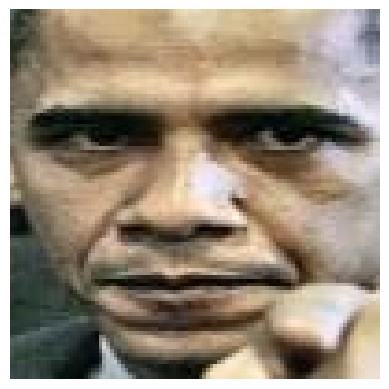

In [23]:
# Load test data
x_test = []
y_test = []

for i, c in enumerate(classes):
    path = os.path.join(test_dir, c)
    for img_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            if greyscale:
                img = cv2.resize(img, (100, 100))
                # Image to greyscale and shape (48, 48, 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = np.expand_dims(img, axis=-1)  # Add channel dimension for greyscale images
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Normalize the image
            img = img / 255.0
            x_test.append(img)
            y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Bruh, why you taking so long..

y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)

# Print one image as matrix
print(x_test[0].shape)
print(type(x_test))
# print(x_test[0])

plt.imshow(x_test[0])
plt.axis('off')
plt.show()

Model saved.
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7832 - loss: 2.1143
[1.4742074012756348, 0.8282268643379211]
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.70      0.74       162
           1       0.59      0.45      0.51       160
           2       0.70      0.47      0.56        74
           3       0.91      0.93      0.92      1185
           4       0.78      0.82      0.80       680
           5       0.78      0.80      0.79       478
           6       0.83      0.84      0.83       329

    accuracy                           0.83      3068
   macro avg       0.77      0.72      0.74      3068
weighted avg       0.82      0.83      0.82      3068

Confusion Matrix:
 [[ 113    5    4   18   11    4    7]
 [   9   72    2   17   29   25    6]
 [   3    4   35    4    2   10   16]
 [   4    6    1 1104   50   13    7]
 [   5   16    2   37  559   44   17]
 [

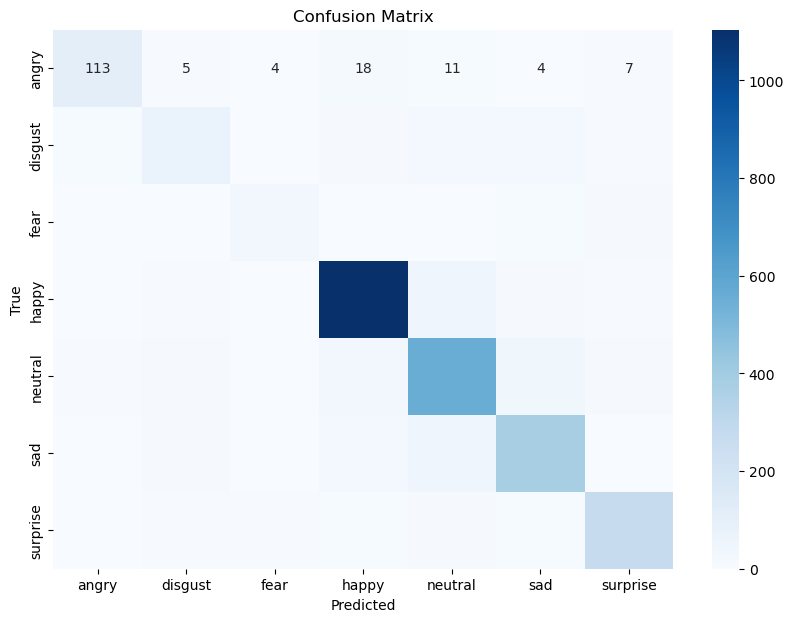

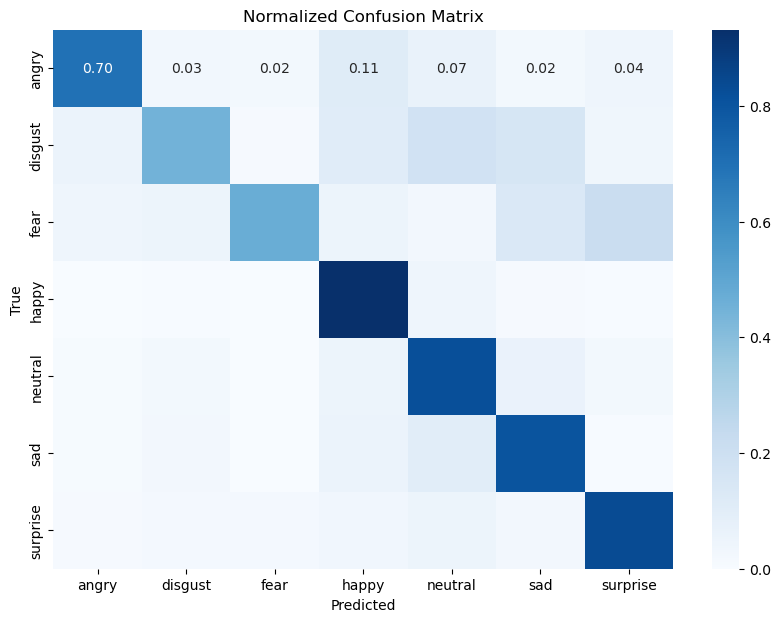

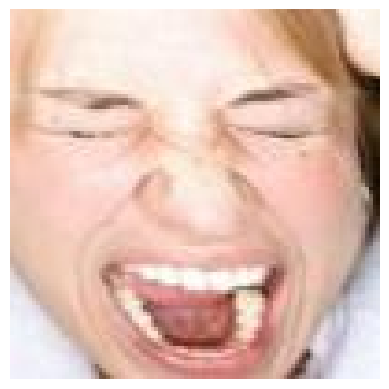

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted emotion: happy


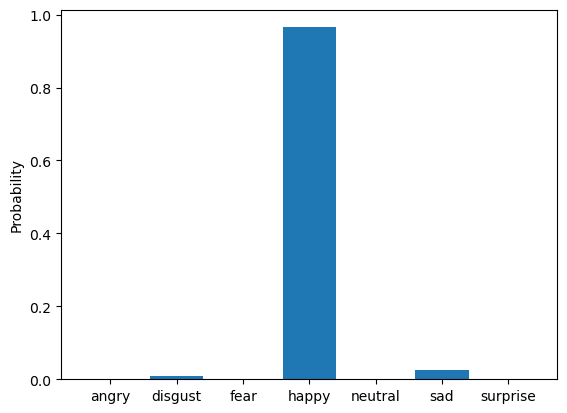

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


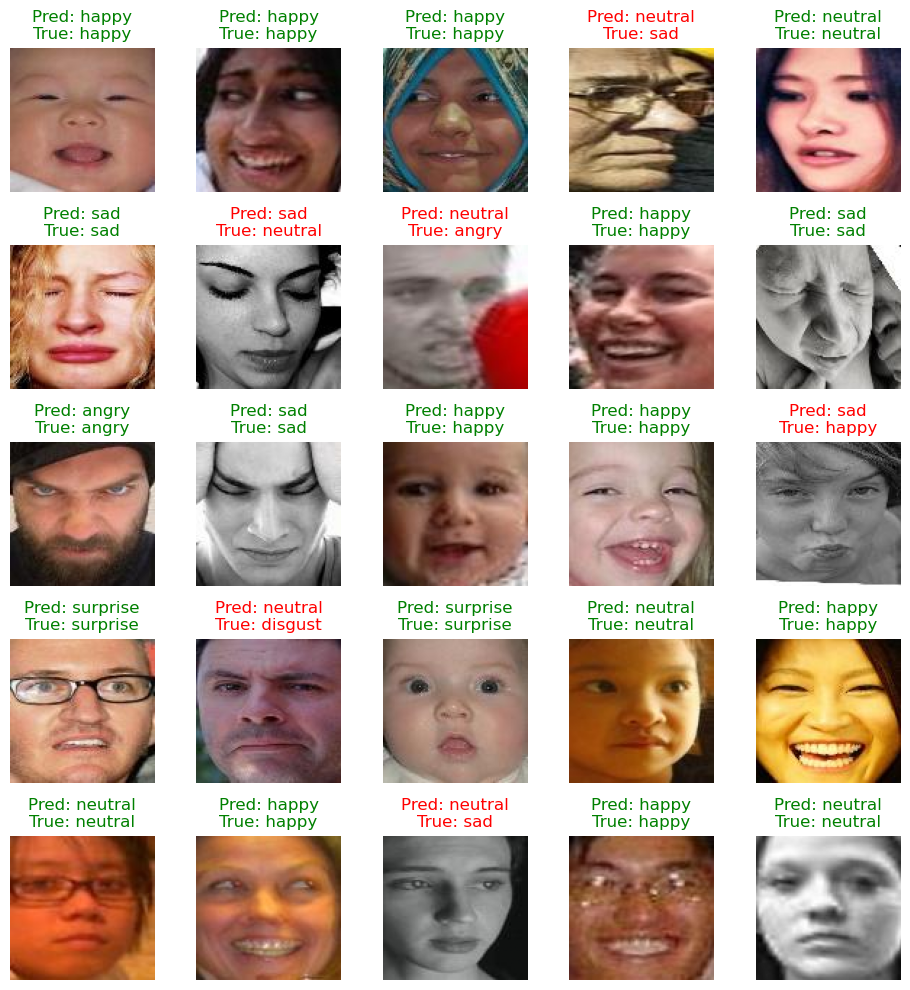

In [27]:
# SAVE MODEL, if model is defined

if model is not None: 
    model.save(modelName + '.keras')
    print('Model saved.')
else:
    # Load model
    model = tf.keras.models.load_model(modelName + '.keras')
    print('Model loaded.')

# Confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate model
evaluation = model.evaluate(x_test, y_test_encoded)

# print evaluation
print(evaluation)

# Predict test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print('Classification Report:\n', classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("Confusion Matrix:\n", cm)
print("Normalized Confusion Matrix:\n", cm_normalized)

# Display confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# TEST MODEL
# Load test image
file_path = 'dataset_RAF_DB/test/angry/test_0037_aligned.jpg'
# random index (with system time as seed)
import random
random.seed()
index = random.randint(0, len(x_test) - 1)
img = x_test[index]

# Display image (back to original size)
# img = np.reshape(img, [100, 100, 3])
plt.imshow(img, cmap='gray' if greyscale else None)
plt.axis('off')
plt.show()

img = x_test[index]
img = np.reshape(img, [1, 100, 100, 3])
# Predict emotion
prediction = model.predict(img)
emotion = classes[np.argmax(prediction)]
print(f'Predicted emotion: {emotion}')

# Display prediction
plt.bar(classes, prediction[0])
plt.ylabel('Probability')
plt.show()

# 5x5 matrix with random pictures from the test set, labeled with the predicted emotion and the true emotion; text color is green if the prediction is correct, red otherwise

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    index = random.randint(0, len(x_test) - 1)
    img = x_test[index]
    img_expanded = np.expand_dims(img, axis=0)
    prediction = model.predict(img_expanded)
    emotion = classes[np.argmax(prediction)]
    true_emotion = classes[y_test[index]]
    color = 'g' if emotion == true_emotion else 'r'
    # Image back to original size
    plt.imshow(img.squeeze(), cmap='gray' if greyscale else None)
    plt.title(f'Pred: {emotion}\nTrue: {true_emotion}', color=color)
    plt.axis('off')
    plt.tight_layout()
    
plt.show()